In [3]:
import torch
import numpy as np
import argparse
import os
import nibabel
import numpy as np
import mne
import pandas as pd
import mne_bids
from transformers import BertTokenizer, BertModel
import time as tm
from wordfreq import zipf_frequency

In [4]:
ph_info = pd.read_csv("phoneme_info.csv")
subjects = pd.read_csv("participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values

In [17]:
def meg_preprocessing(df_new,raw):
    meta = list()
    for annot in raw.annotations:
        d = eval(annot.pop("description"))
        for k, v in annot.items():
            assert k not in d.keys()
            d[k] = v
        meta.append(d)
    meta = pd.DataFrame(meta)
    meta["intercept"] = 1.0

    # compute voicing
    phonemes = meta.query('kind=="phoneme"')
    assert len(phonemes)
    for ph, d in phonemes.groupby("phoneme"):
        ph = ph.split("_")[0]
        match = ph_info.query("phoneme==@ph")
        assert len(match) == 1
        meta.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

    # compute word frquency and merge w/ phoneme
    meta["is_word"] = False
    words = meta.query('kind=="word"').copy()
    assert len(words) > 10
    # assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
    meta.loc[words.index + 1, "is_word"] = True
    wfreq = lambda x: zipf_frequency(x, "en")  # noqa
    meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

    meta = meta.query('kind=="phoneme"')
    assert len(meta.wordfreq.unique()) > 2

    # segment
    events = np.c_[
        meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
    ].astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=-0.2,
        tmax=0.6,
        decim=10,
        baseline=(-0.2, 0.0),
        metadata=meta,
        preload=True,
        event_repeated="drop",
        picks=["meg"]
    )

    # threshold
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    
    return epochs

In [18]:
def load_data(sub,ses,task):
    bids_path = mne_bids.BIDSPath(
    subject = sub, session = ses, task=task, datatype= "meg",
    root = '.')
    
    raw = mne_bids.read_raw_bids(bids_path)
    raw.load_data().filter(0.5, 30.0, n_jobs=1)
    
    df = raw.annotations.to_data_frame()
    df_new = pd.DataFrame(df.description.apply(eval).to_list())
    
    ep = meg_preprocessing(df_new, raw)
    
    ep.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(ep))
            ).astype(int)
    ep.metadata["task"] = ses
    ep.metadata["session"] = task
    
    words = ep["is_word"]
    X = words.get_data() * 1e13
    return ep, X

In [19]:
megdata = []
epochs = []
for i in np.arange(4):
    temp = []
    ep, xx = load_data('01','0',str(i))
    megdata.append(xx)
    epochs.append(ep)

Extracting SQD Parameters from sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff fre

In [24]:
np.save('sub01-meg-data-ses0', megdata)

/home/subbainria/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [36]:
def plot(result):
    fig, ax = plt.subplots(1, figsize=[15, 10])
    sns.lineplot(x="time", y="score", data=result, hue="label", ax=ax)
    ax.axhline(0, color="k")
    return fig

In [27]:
evo_pred = np.load('./meg_sub1_predictions/bert_predictions/0_y_pred_0.npy')
evo_act = np.load('./meg_sub1_predictions/bert_predictions/0_y_test_0.npy')
evo_pred = np.reshape(evo_pred, (evo_pred.shape[0],208, 81))
evo_act = np.reshape(evo_act, (evo_act.shape[0],208, 81))
evo_pred = mne.EpochsArray(evo_pred, epochs[0].info)
evo_act = mne.EpochsArray(evo_act, epochs[0].info)

Not setting metadata
668 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
668 matching events found
No baseline correction applied
0 projection items activated


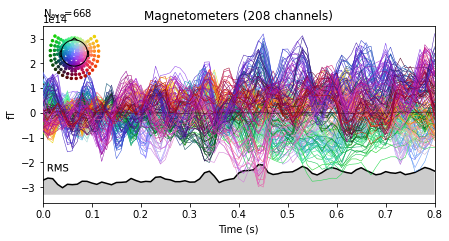

In [54]:
fig_evo_word = evo_act.average().plot(spatial_colors=True, show=False, gfp=True)

No projector specified for this dataset. Please consider the method self.add_proj.


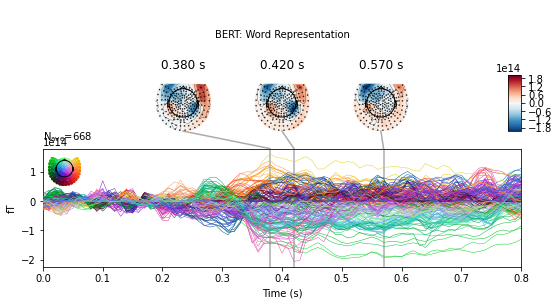

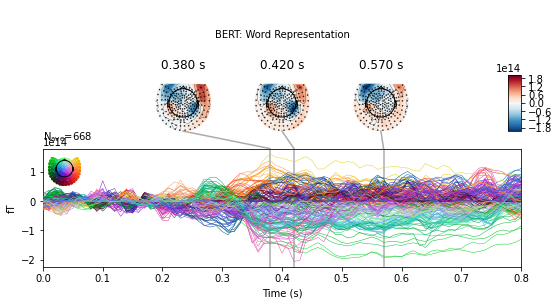

In [57]:
times = np.arange(0.00, 0.8, 0.05)
evo_pred.average().plot_joint(title="BERT: Word Representation", picks='meg')

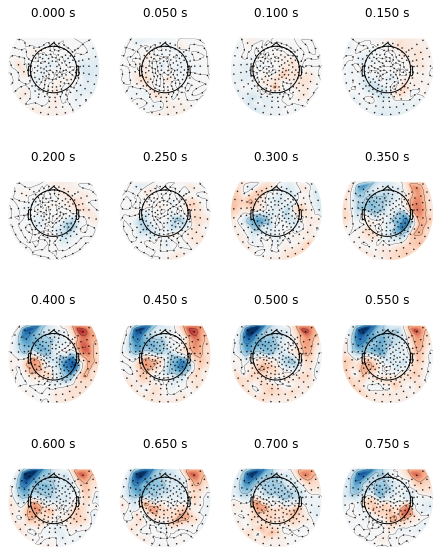

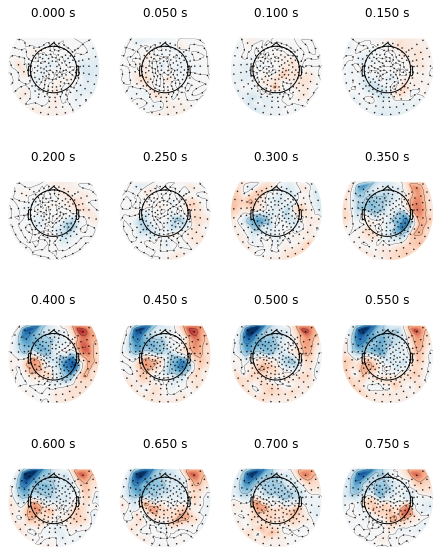

In [56]:
evo_pred.average().plot_topomap(times=times, nrows = 4, ncols=4, colorbar=False)

Not setting metadata
668 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
668 matching events found
No baseline correction applied
0 projection items activated


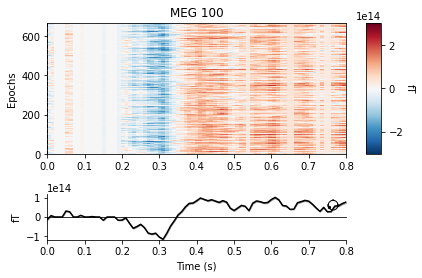

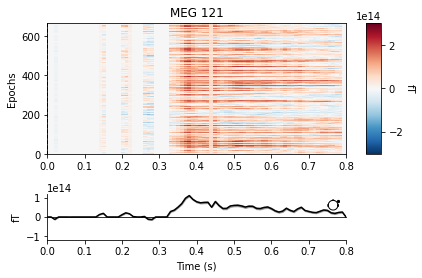

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [33]:
evo_pred.plot_image(picks=['MEG 100', 'MEG 121'])

In [58]:
evo_pred1 = np.load('./meg_sub1_predictions/bert_predictions/0_y_pred_1.npy')
evo_act1 = np.load('./meg_sub1_predictions/bert_predictions/0_y_test_1.npy')
evo_pred1 = np.reshape(evo_pred1, (evo_pred1.shape[0],208, 81))
evo_act1 = np.reshape(evo_act1, (evo_act1.shape[0],208, 81))
evo_pred1 = mne.EpochsArray(evo_pred1, epochs[1].info)
evo_act1 = mne.EpochsArray(evo_act1, epochs[1].info)

Not setting metadata
1503 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1503 matching events found
No baseline correction applied
0 projection items activated


No projector specified for this dataset. Please consider the method self.add_proj.


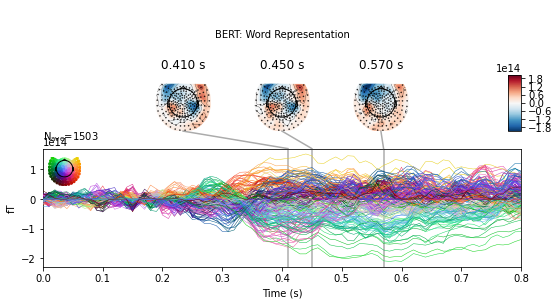

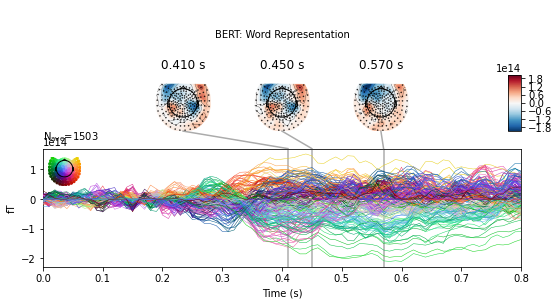

In [59]:
times = np.arange(0.00, 0.8, 0.05)
evo_pred1.average().plot_joint(title="BERT: Word Representation", picks='meg')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/home/subbainria/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


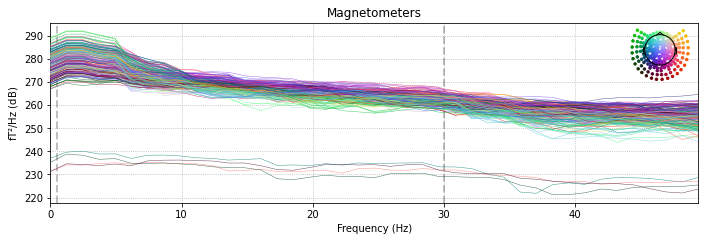

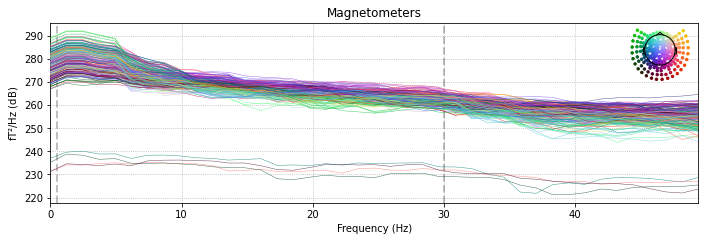

In [61]:
evo_pred1.average().plot_psd()

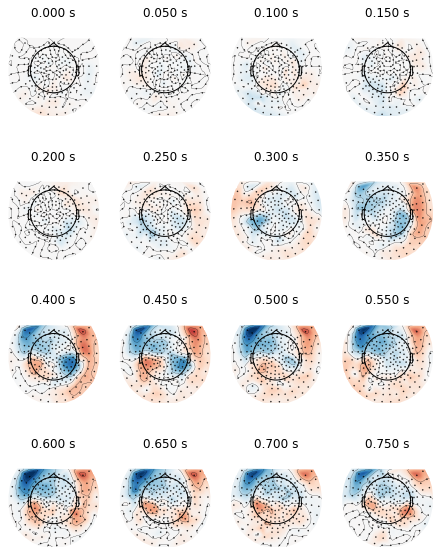

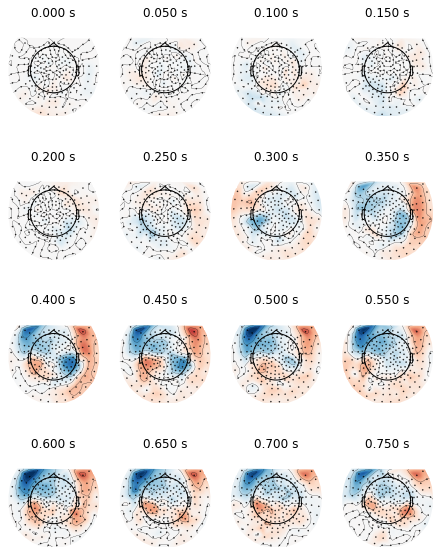

In [60]:
evo_pred1.average().plot_topomap(times=times, nrows = 4, ncols=4, colorbar=False)